# **Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import cv2
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from itertools import cycle
from skimage.feature import local_binary_pattern
from skimage import img_as_ubyte
from tensorflow.keras import backend as K

# Disable warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# **Data Augmentation**

Flipping image virtically and rotating by 90 degree

In [2]:
import os
import shutil
from PIL import Image

def count_images(directory):
    return len([name for name in os.listdir(directory) if name.endswith((".jpg", ".png", ".jpeg"))])

def copy_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            shutil.copy(img_path, output_path)

def flip_images(output_dir):
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            
            # Flip and save the flipped image
            flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_img_path = os.path.join(output_dir, "flipped_" + filename)
            flipped_img.save(flipped_img_path)

def rotate_images(output_dir):
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            
            # Rotate and save the rotated image
            rotated_img = img.rotate(90, expand=True)
            rotated_img_path = os.path.join(output_dir, "rotated_" + filename)
            rotated_img.save(rotated_img_path)

def zoom_images(output_dir, zoom_factor=1.2):
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            
            # Zoom in the image
            width, height = img.size
            new_width = int(width * zoom_factor)
            new_height = int(height * zoom_factor)
            zoomed_img = img.resize((new_width, new_height), Image.LANCZOS)
            
            # Crop back to original size
            left = (new_width - width) / 2
            top = (new_height - height) / 2
            right = (new_width + width) / 2
            bottom = (new_height + height) / 2
            zoomed_img = zoomed_img.crop((left, top, right, bottom))
            
            zoomed_img_path = os.path.join(output_dir, "zoomed_" + filename)
            zoomed_img.save(zoomed_img_path)

inputdir = "/kaggle/input/pox-disease-dataset/Monkeypox Skin Image Dataset"
outputdir = "/kaggle/output/augmented"
diseases = ["Monkeypox", "Chickenpox", "Measles"]

# Clear the output directory before processing
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Clear the output directory
clear_directory(outputdir)

# Keep track of total number of images after each step
for disease in diseases:
    disease_input_dir = os.path.join(inputdir, disease)
    disease_output_dir = os.path.join(outputdir, disease)

    # Copy images
    copy_images(disease_input_dir, disease_output_dir)
    total_images_after_copying = count_images(disease_output_dir)
    print(f"Total images after copying for {disease}: {total_images_after_copying}")

    # Flip images
    flip_images(disease_output_dir)
    total_images_after_flipping = count_images(disease_output_dir)
    print(f"Total images after flipping for {disease}: {total_images_after_flipping}")

    # Rotate images
    rotate_images(disease_output_dir)
    total_images_after_rotating = count_images(disease_output_dir)
    print(f"Total images after rotating for {disease}: {total_images_after_rotating}")
    
    # Zoom images
    zoom_images(disease_output_dir)
    total_images_after_zooming = count_images(disease_output_dir)
    print(f"Total images after zooming for {disease}: {total_images_after_zooming}")

# Print total number of images after all operations
for disease in diseases:
    disease_output_dir = os.path.join(outputdir, disease)
    print(f"Final count of images for {disease}: {count_images(disease_output_dir)}")

Total images after copying for Monkeypox: 279
Total images after flipping for Monkeypox: 558
Total images after rotating for Monkeypox: 1116
Total images after zooming for Monkeypox: 2232
Total images after copying for Chickenpox: 107
Total images after flipping for Chickenpox: 214
Total images after rotating for Chickenpox: 428
Total images after zooming for Chickenpox: 856
Total images after copying for Measles: 91
Total images after flipping for Measles: 182
Total images after rotating for Measles: 364
Total images after zooming for Measles: 728
Final count of images for Monkeypox: 2232
Final count of images for Chickenpox: 856
Final count of images for Measles: 728


# **Memory Optimization Code**

In [3]:
import gc
from tensorflow.keras import backend as K

def optimize_memory():
    # Clear the Keras session to free memory
    K.clear_session()
    
    # Run garbage collection to free up unused memory
    gc.collect()

# **Converting images into negetive images**

In [4]:
def extract_negative_features(image_path, img_size):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    negative_img = cv2.bitwise_not(img_resized)
    negative_img_resized = cv2.resize(negative_img, img_size)
    return negative_img_resized

def create_dataset_with_negative_features(data_dir, img_size, class_names):
    dataset = []
    labels = []
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        label = class_names.index(class_name)
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).resize(img_size)
            img_array = np.array(img) / 255.0
            negative_img = extract_negative_features(img_path, img_size)
            negative_img_flattened = negative_img.flatten()
            img_array_flattened = img_array.flatten()
            combined_features = np.concatenate((img_array_flattened, negative_img_flattened))
            dataset.append(combined_features)
            labels.append(label)
    
    return np.array(dataset), np.array(labels)


Greyscale and negetive image example

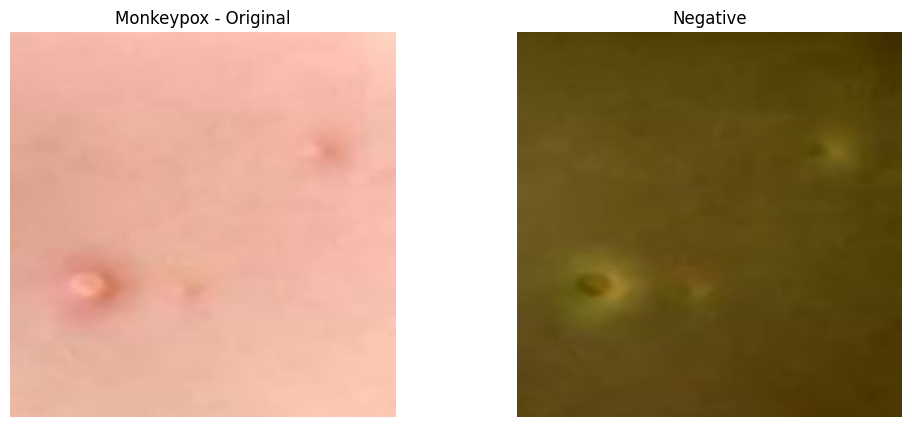

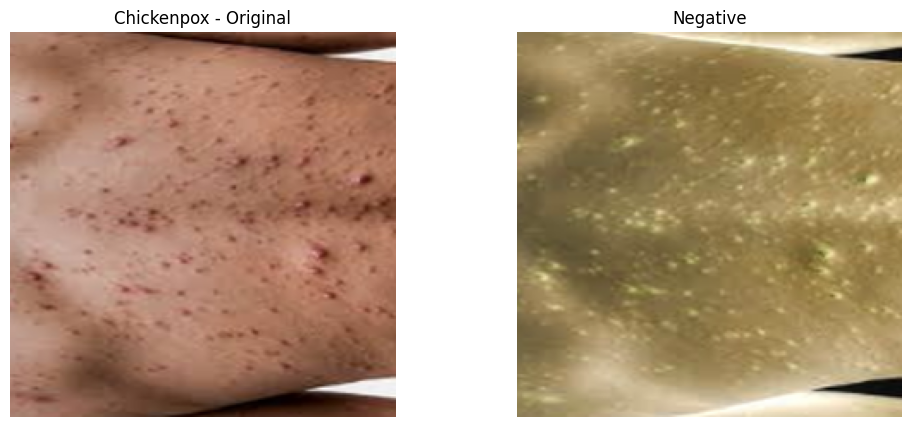

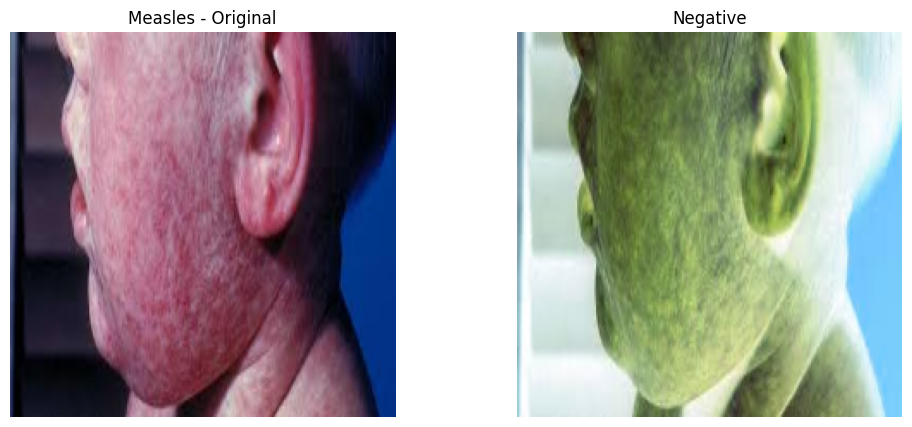

In [5]:
def display_sample_images(data_dir, img_size, class_names):
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        sample_image_path = os.listdir(class_path)[0]
        full_image_path = os.path.join(class_path, sample_image_path)
        negative_img = extract_negative_features(full_image_path, img_size)
        original_img = Image.open(full_image_path).resize(img_size)
        original_img_array = np.array(original_img)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img_array)
        plt.title(f'{class_name} - Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(negative_img, cmap='gray')
        plt.title('Negative')
        plt.axis('off')
        
        plt.show()

data_dir = "/kaggle/output/augmented"
img_size = (224, 224)
class_names = ["Monkeypox", "Chickenpox", "Measles"]

display_sample_images(data_dir, img_size, class_names)


# **Splitting data**

In [6]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define source directory and target directories  # Directory with original dataset
train_dir = '/kaggle/working/train'  # Target directory for training data
val_dir = '/kaggle/working/validation'  # Target directory for validation data

# Create target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to create subdirectories for classes
def create_class_dirs(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# Get class names (assumes each class has its own subfolder in source_dir)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Create class subdirectories in train and validation directories
create_class_dirs(train_dir, class_names)
create_class_dirs(val_dir, class_names)

# Split data into training and validation sets
for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    files = os.listdir(class_folder)
    
    # Shuffle files
    random.shuffle(files)
    
    # Split files into train and validation sets
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)  # 80% train, 20% validation

    # Move files to appropriate directories
    for file in train_files:
        shutil.move(os.path.join(class_folder, file), os.path.join(train_dir, class_name, file))
        
    for file in val_files:
        shutil.move(os.path.join(class_folder, file), os.path.join(val_dir, class_name, file))

print("Data has been split into training and validation sets.")

Data has been split into training and validation sets.


In [7]:
import tensorflow as tf
import numpy as np
import os
import cv2  # or any other image processing library

# Define paths
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = cv2.imread(img_path)  # or any other image reading method
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize to match model input
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_images_from_folder(train_dir)
val_images, val_labels = load_images_from_folder(val_dir)

# Convert labels to numerical format
class_names = sorted(set(train_labels))  # Ensure the class names are consistent
num_classes = len(class_names)
label_to_index = {name: index for index, name in enumerate(class_names)}

train_labels = np.array([label_to_index[label] for label in train_labels])
val_labels = np.array([label_to_index[label] for label in val_labels])

# **Creating Model**

Create the model

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def create_hybrid_model(input_shape_cnn, input_shape_negative, num_classes):
    # VGG16 model for image features
    inputs_cnn = layers.Input(shape=input_shape_cnn)
    weights_path = '/kaggle/input/vgg16/keras/your-uploaded-weights/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg16_base = tf.keras.applications.VGG16(include_top=False, weights=weights_path, input_tensor=inputs_cnn)
    vgg16_base.trainable = True
    
    # Adding custom layers to VGG16 base
    x = vgg16_base.output
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Custom layers for negative image features
    inputs_negative = layers.Input(shape=input_shape_negative)
    y = layers.Dense(256, activation='relu')(inputs_negative)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(128, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.5)(y)
    
    # Combine VGG16 and custom features
    combined = layers.concatenate([x, y])
    combined = layers.Dense(256, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dropout(0.5)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=[inputs_cnn, inputs_negative], outputs=outputs)
    return model

input_shape_cnn = (224, 224, 3)
input_shape_negative = (224 * 224 * 3,)
num_classes = len(class_names)

In [9]:
K.clear_session()

# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


# **Training and Validation**

In [10]:
# Define ExponentialDecay Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)

# Prepare training and validation data
img_data_size = 224 * 224 * 3
negative_data_size = 224 * 224 * 3

# Convert train and validation data to required format
X_train_images = train_images
X_val_images = val_images

# In this example, we are not using negative image features; adjust as needed if you do.
X_train_features = np.zeros((X_train_images.shape[0], negative_data_size))  # Placeholder
X_val_features = np.zeros((X_val_images.shape[0], negative_data_size))    # Placeholder

with strategy.scope():
    model = create_hybrid_model(input_shape_cnn, input_shape_negative, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

history = model.fit(
    [X_train_images, X_train_features],
    tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
    epochs=60,
    batch_size=256,
    validation_data=([X_val_images, X_val_features], tf.keras.utils.to_categorical(val_labels, num_classes=num_classes))
)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate([X_val_images, X_val_features], tf.keras.utils.to_categorical(val_labels, num_classes=num_classes))
print(f"Validation Accuracy: {val_accuracy:.5f}")

Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 130s 7s/step - accuracy: 0.3916 - loss: 1.6628 - val_accuracy: 0.3655 - val_loss: 4.4588
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5625 - loss: 1.1069 - val_accuracy: 0.3603 - val_loss: 11.1750
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6298 - loss: 0.9897 - val_accuracy: 0.6397 - val_loss: 1.9989
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6672 - loss: 0.9131 - val_accuracy: 0.7911 - val_loss: 1.0632
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7231 - loss: 0.7644 - val_accuracy: 0.8329 - val_loss: 0.4782
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7175 - loss: 0.7251 - val_accuracy: 0.7389 - val_loss: 0.8998
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7784 - loss: 0.6215 - val_accuracy: 0.6005 - val_loss: 1.5255
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8002 - loss: 0.5741 - val_accuracy: 0.8695 - val_los

# **Plotting graphs**

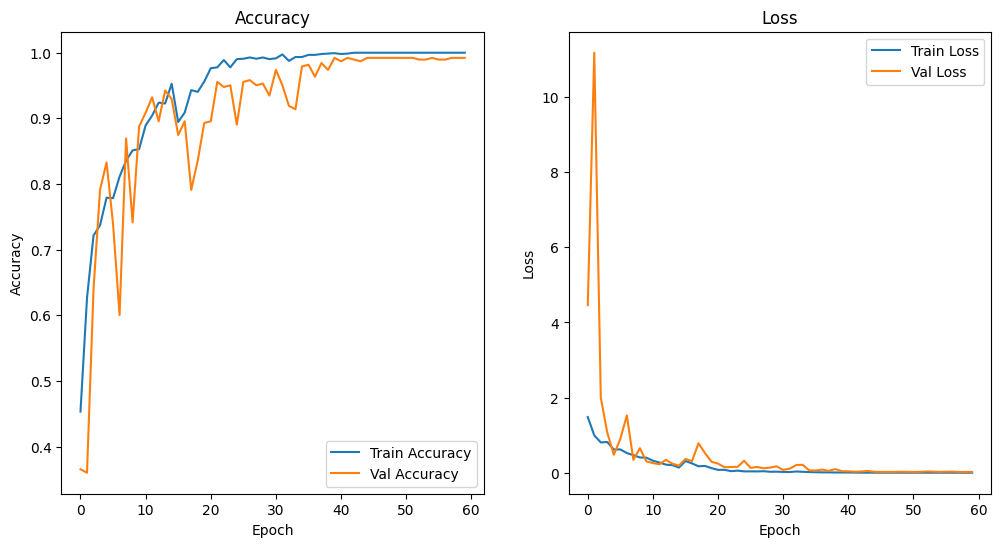

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


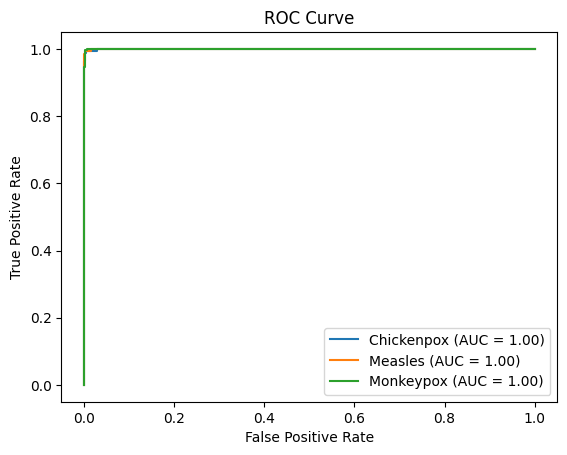

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


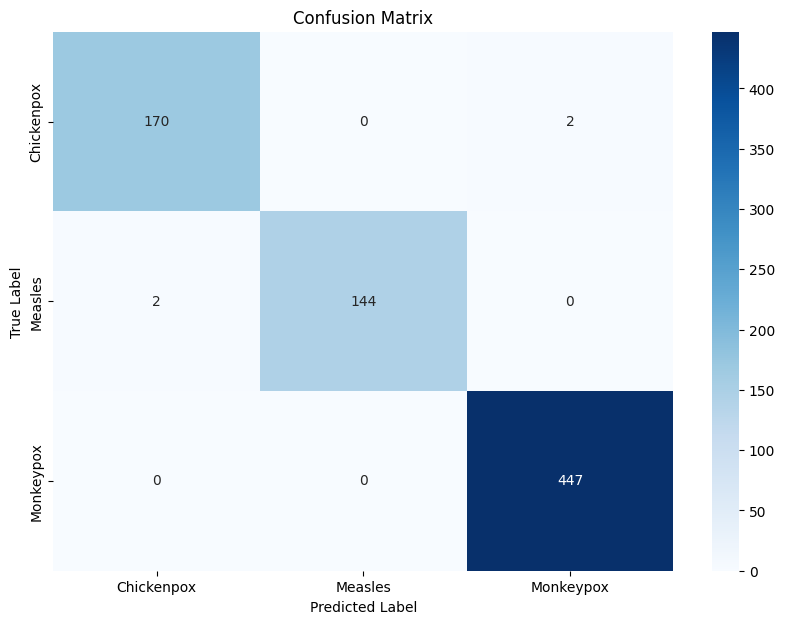

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.99      0.99      0.99       172
     Measles       1.00      0.99      0.99       146
   Monkeypox       1.00      1.00      1.00       447

    accuracy                           0.99       765
   macro avg       0.99      0.99      0.99       765
weighted avg       0.99      0.99      0.99       765



In [11]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC Curve
from sklearn.metrics import roc_auc_score
y_val_one_hot = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
y_val_prob = model.predict([X_val_images, X_val_features])
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_one_hot[:, i], y_val_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc_score(y_val_one_hot[:, i], y_val_prob[:, i]):.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_val_pred = np.argmax(model.predict([X_val_images, X_val_features]), axis=-1)
cm = confusion_matrix(val_labels, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

cr = classification_report(val_labels, y_val_pred, target_names=class_names)
print(f"Classification Report:\n", cr)

Accuracy and Loss Graph